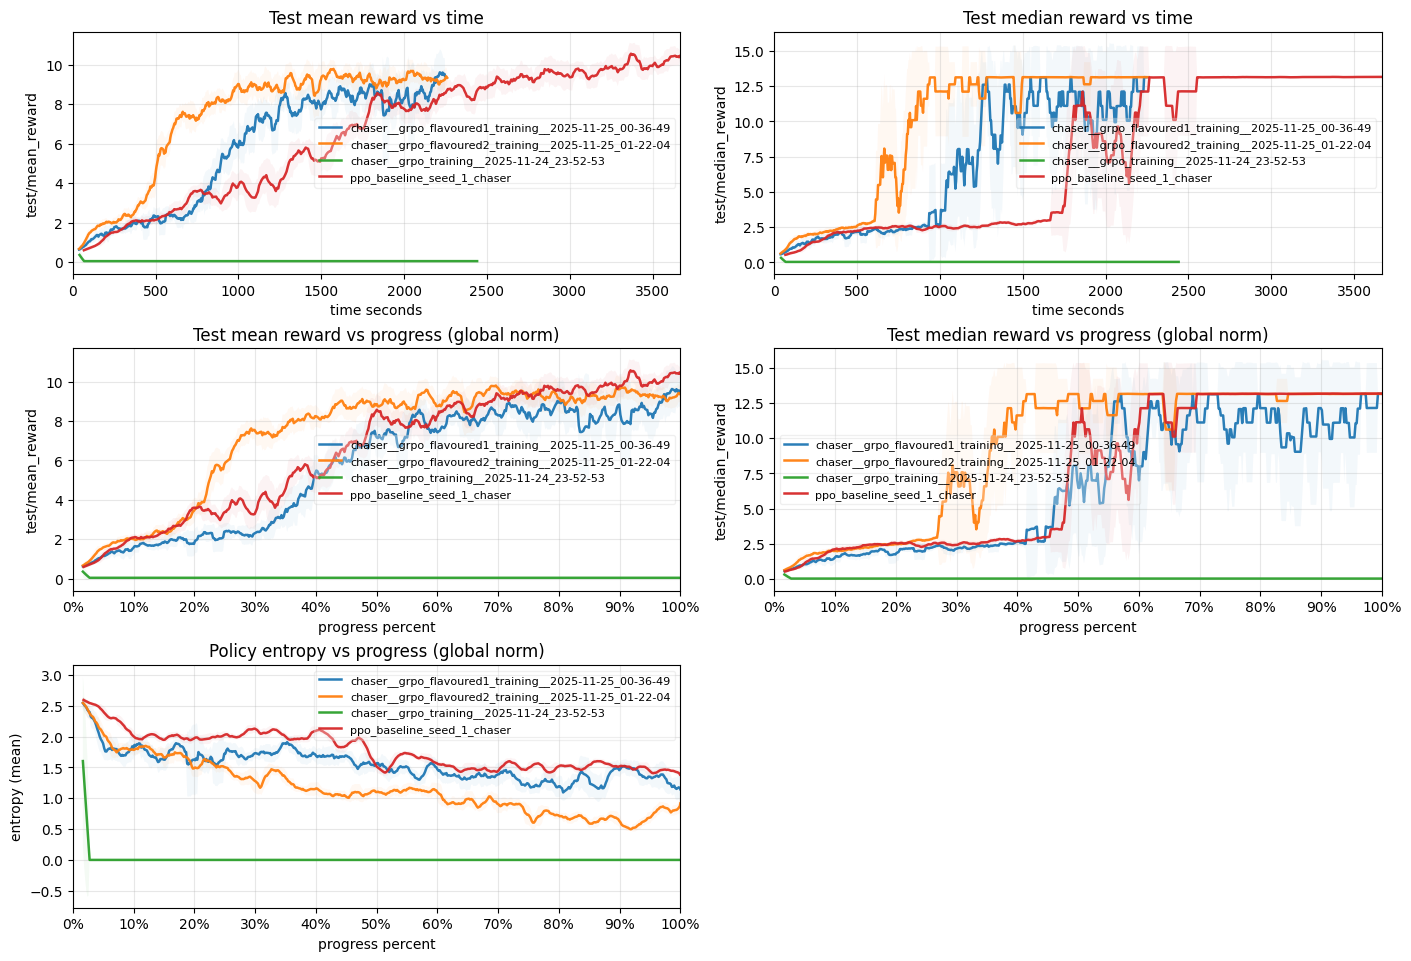

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

ROOT_DIR = "./ouputs_chaser"
CSV_NAME = "sit_format.csv"

REQUIRED_COLS = [
    "training_time",
    "total_steps",
    "test/mean_reward",
    "test/median_reward",
    "loss/dist_entropy",
]

PLOTS = [
    {"x": "t", "y": "test/mean_reward", "xlabel": "time seconds", "ylabel": "test/mean_reward", "title": "Test mean reward vs time"},
    {"x": "t", "y": "test/median_reward", "xlabel": "time seconds", "ylabel": "test/median_reward", "title": "Test median reward vs time"},
    {"x": "steps_norm_global", "y": "test/mean_reward", "xlabel": "progress percent", "ylabel": "test/mean_reward", "title": "Test mean reward vs progress (global norm)"},
    {"x": "steps_norm_global", "y": "test/median_reward", "xlabel": "progress percent", "ylabel": "test/median_reward", "title": "Test median reward vs progress (global norm)"},
    {"x": "steps_norm_global", "y": "loss/dist_entropy", "xlabel": "progress percent", "ylabel": "entropy (mean)", "title": "Policy entropy vs progress (global norm)"},
]

ROLL_WINDOW = 10
UNCERTAINTY_SCALE = 1.0
BAND_ALPHA = 0.05

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_plot")

def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)

def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def ensure_numeric(series, name):
    if series is None:
        raise ValueError(f"Column '{name}' missing")
    v = pd.to_numeric(series, errors="raise").astype(float).values
    if v.size == 0 or not np.isfinite(v).any():
        raise ValueError(f"Column '{name}' has no finite numeric values")
    return v

def build_time_seconds(df):
    t = ensure_numeric(df["training_time"], "training_time")
    t0 = np.nanmin(t)
    if not np.isfinite(t0):
        raise ValueError("training_time min not finite")
    if t0 != 0:
        t = t - t0
    return t

def normalize_time_per_run(t):
    total = np.nanmax(t)
    if not np.isfinite(total) or total <= 0:
        raise ValueError("training_time max invalid for normalization")
    return np.clip(t / float(total), 0.0, np.inf)

def build_steps(df):
    steps = ensure_numeric(df["total_steps"], "total_steps")
    s0 = np.nanmin(steps)
    if not np.isfinite(s0):
        raise ValueError("total_steps min not finite")
    if s0 != 0:
        steps = steps - s0
    return steps

def smooth_series(y):
    s = pd.Series(y, dtype=float)
    return s.rolling(ROLL_WINDOW, min_periods=ROLL_WINDOW).mean().values

def uncertainty_series(y):
    s = pd.Series(y, dtype=float)
    std = s.rolling(ROLL_WINDOW, min_periods=ROLL_WINDOW).std(ddof=1)
    return std.values

def load_runs(root):
    paths = find_run_csvs(root, CSV_NAME)
    if not paths:
        logger.error(f"No CSVs named '{CSV_NAME}' found under root='{root}'")
        return pd.DataFrame()

    frames = []
    for p in paths:
        run = infer_run_name(p, root)
        try:
            df = pd.read_csv(p)
            missing = [c for c in REQUIRED_COLS if c not in df.columns]
            if missing:
                raise ValueError(f"Missing required columns: {missing}")

            t = build_time_seconds(df)
            tn = normalize_time_per_run(t)
            steps = build_steps(df)

            y_mean = ensure_numeric(df["test/mean_reward"], "test/mean_reward")
            y_median = ensure_numeric(df["test/median_reward"], "test/median_reward")
            entropy_col = ensure_numeric(df["loss/dist_entropy"], "loss/dist_entropy")

            sub = pd.DataFrame({
                "run": run,
                "t": t,
                "t_norm": tn,
                "steps": steps,
                "test/mean_reward": y_mean,
                "test/median_reward": y_median,
                "loss/dist_entropy": entropy_col,
            })

            sub = sub.sort_values("t_norm")
            frames.append(sub)

        except Exception as e:
            logger.error(f"[{run}] skipping due to error: {e}")
            continue

    if not frames:
        logger.error("No valid runs loaded after strict validation")
        return pd.DataFrame()

    df_all = pd.concat(frames, ignore_index=True)

    smax_global = np.nanmax(df_all["steps"].values)
    if not np.isfinite(smax_global) or smax_global <= 0:
        logger.error("Global total_steps max invalid for normalization")
        return df_all

    df_all["steps_norm_global"] = np.clip(df_all["steps"].values / float(smax_global), 0.0, 1.0)
    return df_all

def plot_runs(ax, df, runs, x, y, xlabel, ylabel, title):
    plotted_any = False
    for r in runs:
        d = df[df["run"] == r]
        xv = d[x].values
        yv = d[y].values

        if yv.size == 0 or np.all(~np.isfinite(yv)):
            logger.error(f"[{r}] plot '{title}' y='{y}' invalid; strict mode skips")
            continue

        ys = smooth_series(yv)
        u = uncertainty_series(yv)
        mask = np.isfinite(xv) & np.isfinite(ys) & np.isfinite(u)
        xv2, ys2, u2 = xv[mask], ys[mask], u[mask]

        if xv2.size == 0:
            logger.error(f"[{r}] plot '{title}' insufficient finite points after smoothing")
            continue

        ax.plot(xv2, ys2, label=r, linewidth=1.8, alpha=0.95)
        ax.fill_between(xv2, ys2 - UNCERTAINTY_SCALE * u2, ys2 + UNCERTAINTY_SCALE * u2, alpha=BAND_ALPHA, linewidth=0)
        plotted_any = True

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if x == "t_norm":
        ax.set_xlim(0, 1.0)
    elif x == "t":
        xmax = np.nanmax(df["t"].values)
        if np.isfinite(xmax):
            ax.set_xlim(0, xmax)
    elif x == "steps_norm_global":
        ax.set_xlim(0, 1.0)
        bp = np.arange(0.0, 1.0 + 1e-9, 0.1)
        ax.set_xticks(bp)
        ax.set_xticklabels([f"{int(v*100)}%" for v in bp])

    ax.grid(True, alpha=0.3)
    if plotted_any:
        ax.legend(loc="best", fontsize=8, framealpha=0.3)
    else:
        logger.error(f"No lines plotted for '{title}'")

def main():
    df = load_runs(ROOT_DIR)
    if df.empty:
        print(f"No {CSV_NAME} files with required columns found under: {ROOT_DIR}")
        return

    runs = df["run"].unique().tolist()
    if not runs:
        print(f"No valid runs after strict validation under: {ROOT_DIR}")
        return

    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(14, 9.5), constrained_layout=True)
    axes = axes.flatten()

    for i, cfg in enumerate(PLOTS):
        plot_runs(axes[i], df, runs, **cfg)

    for j in range(len(PLOTS), rows * cols):
        fig.delaxes(axes[j])

    plt.show()

if __name__ == "__main__":
    main()


WARNING | [fruitbot__grpo_training__2025-11-23_21-27-27] could not parse p/m from run name; got p=nan, m=nan
WARNING | [fruitbot__grpo_training_v2__2025-11-23_23-10-41] could not parse p/m from run name; got p=nan, m=nan


,run,p,m,mean_lastN_winsor,median_lastN_winsor
0,fruitbot__grpo_training__2025-11-23_21-27-27,NaN,NaN,16.672340,15.71
1,fruitbot__grpo_training_v2__2025-11-23_23-10-41,NaN,NaN,19.910418,22.24


,p,m,mean_lastN_winsor,median_lastN_winsor


/tmp/ipykernel_37768/86486440.py:174: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm)
/tmp/ipykernel_37768/86486440.py:174: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm)
/tmp/ipykernel_37768/86486440.py:174: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm)
/tmp/ipykernel_37768/86486440.py:174: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm)


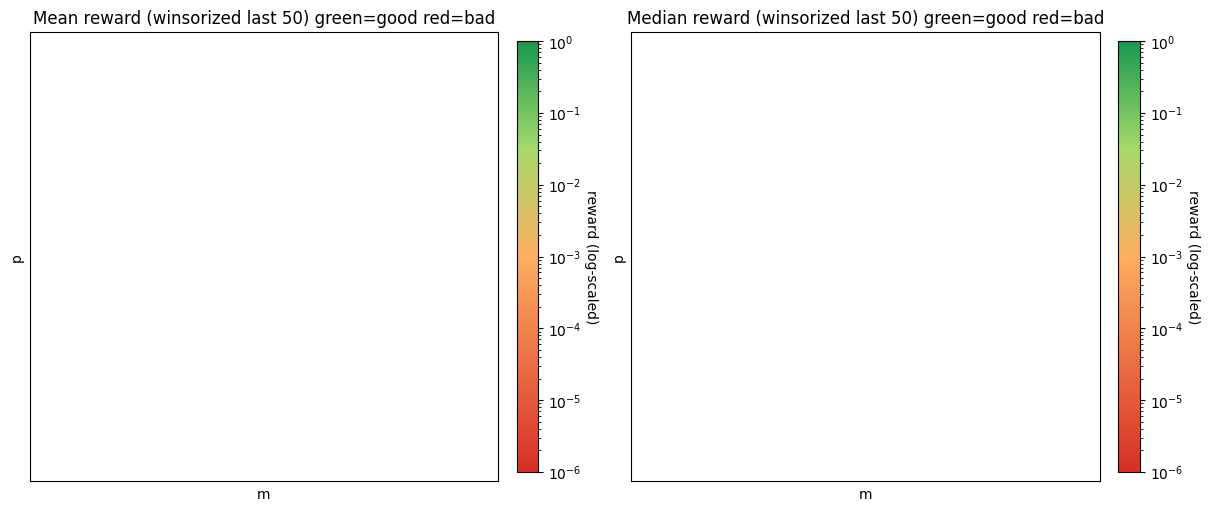

In [22]:
import os
import re
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, SymLogNorm

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"

Y_MEAN = "test/mean_episode_reward"
Y_MEDIAN = "test/median_episode_reward"
Y_MEAN_ALIASES = [Y_MEAN, "test/mean_reward"]
Y_MEDIAN_ALIASES = [Y_MEDIAN, "test/median_reward"]

LAST_N = 50
WINSOR_Q = 0.10

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_matrix_nb")

def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    paths = sorted(paths)
    if not paths:
        logger.warning(f"No CSVs named '{csv_name}' found under root='{root}'")
    return paths

def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def parse_p_m_from_run(run_name):
    p_match = re.search(r"p([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    m_match = re.search(r"m([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    p = float(p_match.group(1)) if p_match else np.nan
    m = float(m_match.group(1)) if m_match else np.nan
    if not np.isfinite(p) or not np.isfinite(m):
        logger.warning(f"[{run_name}] could not parse p/m from run name; got p={p}, m={m}")
    return p, m

def get_first_present(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def _nan_masked_tail(series, n):
    x = pd.to_numeric(pd.Series(series), errors="coerce").dropna().values
    if x.size == 0:
        return x
    n_eff = min(n, x.size) if n is not None and n > 0 else x.size
    return x[-n_eff:]

def winsorized_mean_lastN(series, n, q):
    x = _nan_masked_tail(series, n)
    if x.size == 0:
        return np.nan
    if x.size < 3:
        return float(np.mean(x))
    q = max(0.0, min(0.5, q))
    if q == 0.0:
        return float(np.mean(x))
    lo, hi = np.quantile(x, [q, 1 - q])
    xw = np.clip(x, lo, hi)
    return float(np.mean(xw))

def load_last_metrics(root):
    paths = find_run_csvs(root, CSV_NAME)
    rows = []
    for pth in paths:
        run = infer_run_name(pth, root)
        try:
            df = pd.read_csv(pth)
        except Exception as e:
            logger.error(f"[{run}] failed to read CSV '{pth}': {e}")
            continue
        y_mean_col = get_first_present(df, Y_MEAN_ALIASES)
        y_median_col = get_first_present(df, Y_MEDIAN_ALIASES)
        if y_mean_col is None and y_median_col is None:
            logger.warning(f"[{run}] missing target columns; looked for {Y_MEAN_ALIASES} and {Y_MEDIAN_ALIASES}; skipping")
            continue
        mean_series = df.get(y_mean_col, pd.Series(dtype=float))
        median_series = df.get(y_median_col, pd.Series(dtype=float))
        mean_est = winsorized_mean_lastN(mean_series, LAST_N, WINSOR_Q) if y_mean_col is not None else np.nan
        median_est = winsorized_mean_lastN(median_series, LAST_N, WINSOR_Q) if y_median_col is not None else np.nan
        if np.isnan(mean_est) and np.isnan(median_est):
            logger.warning(f"[{run}] last-N robust estimators returned NaN for both mean/median; skipping")
            continue
        p_val, m_val = parse_p_m_from_run(run)
        rows.append({
            "run": run,
            "p": p_val,
            "m": m_val,
            "mean_lastN_winsor": mean_est,
            "median_lastN_winsor": median_est,
        })
    return rows

def build_matrices(rows):
    df = pd.DataFrame(rows)
    if df.empty:
        return np.array([]), np.array([]), np.array([[]]), np.array([[]]), pd.DataFrame(columns=["p","m","mean_lastN_winsor","median_lastN_winsor"])
    P_vals = np.sort(df["p"].dropna().unique())
    M_vals = np.sort(df["m"].dropna().unique())
    mean_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    median_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    grouped = df.groupby(["p", "m"], dropna=True).agg({
        "mean_lastN_winsor": "mean",
        "median_lastN_winsor": "mean"
    }).reset_index()
    p_index = {p: i for i, p in enumerate(P_vals)}
    m_index = {m: j for j, m in enumerate(M_vals)}
    for _, row in grouped.iterrows():
        p, m = row["p"], row["m"]
        if p in p_index and m in m_index:
            i, j = p_index[p], m_index[m]
            mean_matrix[i, j] = row["mean_lastN_winsor"]
            median_matrix[i, j] = row["median_lastN_winsor"]
    tidy = pd.DataFrame({
        "p": np.repeat(P_vals, len(M_vals)),
        "m": np.tile(M_vals, len(P_vals)),
        "mean_lastN_winsor": mean_matrix.reshape(-1),
        "median_lastN_winsor": median_matrix.reshape(-1),
    })
    return P_vals, M_vals, mean_matrix, median_matrix, tidy

def make_green_good_red_bad_cmap():
    colors = [
        (0.0, "#d73027"),
        (0.5, "#fdae61"),
        (0.75, "#a6d96a"),
        (1.0, "#1a9850"),
    ]
    return LinearSegmentedColormap.from_list("red_yellow_green", colors)

rows = load_last_metrics(ROOT_DIR)
if not rows:
    print(f"No valid runs found to build matrices from: {ROOT_DIR}")
else:
    P_vals, M_vals, mean_matrix, median_matrix, tidy = build_matrices(rows)

    try:
        display(pd.DataFrame(rows))
        display(tidy)
    except NameError:
        print(pd.DataFrame(rows).head())
        print(tidy.head())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    cmap = make_green_good_red_bad_cmap()

    def imshow_with_axes(ax, matrix, P_vals, M_vals, title):
        finite_vals = matrix[np.isfinite(matrix)]
        if finite_vals.size == 0:
            vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = np.nanmin(finite_vals), np.nanmax(finite_vals)
            if np.isclose(vmin, vmax):
                delta = 1.0 if vmax == 0 else abs(vmax) * 0.1
                vmin, vmax = vmax - delta, vmax + delta
        if finite_vals.size == 0:
            norm = LogNorm(vmin=1e-6, vmax=1.0)
        elif np.all(finite_vals > 0):
            eps = np.nextafter(0, 1)
            norm = LogNorm(vmin=max(vmin, eps), vmax=vmax)
        else:
            linthresh = max(1e-6, 0.01 * max(1e-9, (vmax - vmin)))
            norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)
        im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm)
        ax.set_title(title)
        ax.set_xlabel("m")
        ax.set_ylabel("p")
        ax.set_xticks(range(len(M_vals)))
        ax.set_yticks(range(len(P_vals)))
        ax.set_xticklabels([f"{m:g}" for m in M_vals], rotation=45, ha="right")
        ax.set_yticklabels([f"{p:g}" for p in P_vals])
        im.cmap.set_bad(color="#bdbdbd")
        im.set_data(np.ma.masked_invalid(matrix))
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("reward (log-scaled)", rotation=270, labelpad=12)

    imshow_with_axes(axes[0], mean_matrix, P_vals, M_vals, f"Mean reward (winsorized last {LAST_N}) green=good red=bad")
    imshow_with_axes(axes[1], median_matrix, P_vals, M_vals, f"Median reward (winsorized last {LAST_N}) green=good red=bad")

    plt.show()
